Structure largely follows Keras examples 
* https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb
* 

## To Do 
added the gender and age categorical variables as inputs
automated hyperparameter estimation

## Changes

* 4 Added other MFCC metrics as numerical features from my preprocess script, added the gender and age categorical variables as inputs
* 3 added MFCC from my preprocessing scripts, added classification and class-imbalance metrics and performance improved to 80%+ accuracy
* 2 used MFCC calculated from the SAIE dataset from the method given in the script


In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.17.0'

In [3]:
import librosa
from pydub import AudioSegment
import soundfile as sf
import ffmpeg
from IPython.display import Audio

C:\Users\GGMachines_Gaming\.conda\envs\audio8_2_tf\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
import pandas as pd
import numpy as np
import os

In [153]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
librosa.__version__

'0.10.2.post1'

## File inputs and GLOBAL VARIABLES

In [ ]:
file_class=pd.read_csv('file_class.csv',index_col=0) #"C:\Users\GGMachines_Gaming\Documents\voxpop\file_class.df"

In [ ]:
os.getcwd()

In [8]:
INPUT_DIRECTORY='C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\' #i9 machine

In [31]:
TRAIN_TEST_SPLIT = 0.80

In [16]:
## Used in versions 1,2 instead of my preprocessing output

# file_class=pd.read_csv('file_class.csv',index_col=0) #"C:\Users\GGMachines_Gaming\Documents\voxpop\file_class.df"
# file_class.shape

In [14]:
dub_df = pd.read_pickle('C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\sample_output_directory\\20240721_0000_DUB_features.pkl') #i9 directory

In [15]:
antbel_df = pd.read_pickle('C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\sample_output_directory\\20240721_0013_ANT_features.pkl') #i9 directory

## Reset recording numbers

In [17]:
recordings_count=dub_df['recording num'].max()
recordings_count

166

In [18]:
#Increase the recording number in the 2nd dataframe so that there are no duplicates
antbel_df['recording num']=dub_df['recording num']+recordings_count
antbel_df['recording num']

0       166
1       166
2       166
3       166
4       166
       ... 
6489    237
6490    237
6491    237
6492    237
6493    237
Name: recording num, Length: 6494, dtype: object

# Merge the DataFrames

In [321]:
# Concatenate the DataFrames
all_df= pd.concat([antbel_df, dub_df], ignore_index=True)


In [322]:
all_df.shape

(21594, 18)

In [323]:
all_df.iloc[0:4]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,0,ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav,"[-3.259629e-09, -1.9790605e-09, -1.8626451e-09...","[[-35.601192, -23.076942, -25.175114, -30.8771...",22050,"[[-494.3632, -314.76587, -256.5209, -248.23921...","[[22.54509, 22.54509, 22.54509, 22.54509, 22.5...","[[-13.363751, -13.363751, -13.363751, -13.3637..."
1,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,1,ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav,"[-0.063719966, 0.018594107, 0.042440787, 0.011...","[[-24.939114, -19.037073, -35.540073, -40.6882...",22050,"[[-200.87267, -189.22813, -205.93425, -217.350...","[[1.7263998, 1.7263998, 1.7263998, 1.7263998, ...","[[8.442614, 8.442614, 8.442614, 8.442614, 8.44..."
2,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,2,ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav,"[-0.009588398, -0.029184137, -0.023096263, -0....","[[-12.003866, -22.771717, -25.912066, -27.5487...",22050,"[[-269.9958, -209.71855, -199.9971, -192.51334...","[[7.1880474, 7.1880474, 7.1880474, 7.1880474, ...","[[-7.412616, -7.412616, -7.412616, -7.412616, ..."
3,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,3,ANT_Antrim_R1_F_20_Rec_0_Sample_3.wav,"[-0.02926175, -0.03246651, -0.03447114, -0.032...","[[-33.829704, -37.727036, -24.553106, -31.8029...",22050,"[[-319.19656, -307.64944, -314.54547, -295.997...","[[9.711183, 9.711183, 9.711183, 9.711183, 9.71...","[[-0.45292982, -0.45292982, -0.45292982, -0.45..."


In [258]:
# One-hot encoding: Put one column in for every value of the categorical variables

all_df = pd.get_dummies(all_df, columns=['genders','ages'],prefix=[None,None])

In [318]:
all_df.iloc[0:4,-18:-1]

,mfcc_delta_2,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80
0,"[[-13.363751, -13.363751, -13.363751, -13.3637...",True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,"[[8.442614, 8.442614, 8.442614, 8.442614, 8.44...",True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,"[[-7.412616, -7.412616, -7.412616, -7.412616, ...",True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,"[[-0.45292982, -0.45292982, -0.45292982, -0.45...",True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [264]:
counties=all_df['counties']

In [265]:
all_df['counties'] = all_df['counties'].replace({'ANT': 'ANTBEL', 'BEL': 'ANTBEL'})

In [266]:
all_df['counties'].value_counts()

counties
DUB       15100
ANTBEL     6494
Name: count, dtype: int64

In [267]:
print(all_df['counties'].shape)

(21594,)


In [268]:
all_df['y'] = all_df['counties'].replace({'ANTBEL':1, 'DUB': 0})

C:\Users\GGMachines_Gaming\AppData\Local\Temp\ipykernel_31928\3374583436.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df['y'] = all_df['counties'].replace({'ANTBEL':1, 'DUB': 0})


In [269]:
all_df['y']

0        1
1        1
2        1
3        1
4        1
        ..
21589    0
21590    0
21591    0
21592    0
21593    0
Name: y, Length: 21594, dtype: int64

In [270]:
all_df['y'].value_counts()

y
0    15100
1     6494
Name: count, dtype: int64

In [271]:
## Split into train and test datasets - make sure speakers are not split between them

# Count the unique recording values, then shuffle the unique values
unique_recordings = all_df['recording num'].unique()
np.random.shuffle(unique_recordings)  

# Determine the split index
split_index = int(len(unique_recordings) * TRAIN_TEST_SPLIT)
print(split_index)

190


In [272]:
unique_recordings

array([130, 202, 78, 174, 98, 158, 185, 48, 8, 1, 147, 177, 146, 74, 32,
       140, 7, 83, 141, 237, 231, 27, 190, 45, 15, 0, 179, 129, 175, 105,
       152, 178, 20, 216, 90, 221, 138, 201, 66, 11, 121, 164, 166, 86,
       235, 116, 167, 104, 131, 218, 136, 9, 23, 145, 172, 188, 133, 173,
       72, 117, 206, 60, 132, 151, 222, 189, 46, 168, 194, 155, 70, 186,
       180, 31, 89, 123, 219, 103, 169, 212, 82, 229, 181, 125, 67, 161,
       41, 207, 225, 55, 85, 75, 139, 29, 134, 40, 42, 22, 12, 26, 203,
       118, 76, 156, 30, 204, 205, 114, 80, 165, 62, 64, 39, 10, 69, 232,
       198, 59, 3, 210, 58, 88, 149, 73, 220, 228, 50, 61, 195, 43, 84,
       226, 79, 36, 97, 191, 120, 215, 144, 153, 49, 171, 5, 47, 217, 197,
       162, 170, 24, 14, 157, 143, 56, 208, 2, 21, 102, 44, 227, 106, 111,
       92, 81, 87, 223, 100, 196, 209, 135, 37, 183, 16, 77, 148, 38, 128,
       65, 93, 13, 53, 126, 214, 17, 154, 91, 184, 213, 159, 94, 234, 57,
       96, 4, 230, 113, 101, 187, 71, 35, 11

In [273]:
# Split the unique values into two sets for train and test datasets WITH DIFFERENT SPEAKERS IN EACH
recording_train = unique_recordings[:split_index]
recording_test = unique_recordings[split_index:]

In [274]:
print(recording_train) # TRAIN portion of the randomly shuffled dataset

[130 202 78 174 98 158 185 48 8 1 147 177 146 74 32 140 7 83 141 237 231
 27 190 45 15 0 179 129 175 105 152 178 20 216 90 221 138 201 66 11 121
 164 166 86 235 116 167 104 131 218 136 9 23 145 172 188 133 173 72 117
 206 60 132 151 222 189 46 168 194 155 70 186 180 31 89 123 219 103 169
 212 82 229 181 125 67 161 41 207 225 55 85 75 139 29 134 40 42 22 12 26
 203 118 76 156 30 204 205 114 80 165 62 64 39 10 69 232 198 59 3 210 58
 88 149 73 220 228 50 61 195 43 84 226 79 36 97 191 120 215 144 153 49 171
 5 47 217 197 162 170 24 14 157 143 56 208 2 21 102 44 227 106 111 92 81
 87 223 100 196 209 135 37 183 16 77 148 38 128 65 93 13 53 126 214 17 154
 91 184 213 159 94 234]


In [275]:
print(recording_test) # TEST portion of the randomly shuffled dataset

[57 96 4 230 113 101 187 71 35 110 150 182 233 112 193 107 115 236 163 124
 51 109 224 33 108 68 160 63 137 95 142 211 18 176 34 6 192 19 54 122 200
 28 127 52 99 119 25 199]


In [276]:
# Create two new DataFrames based on the split unique values
train_df = all_df[all_df['recording num'].isin(recording_train)].reset_index(drop=True)
test_df = all_df[all_df['recording num'].isin(recording_test)].reset_index(drop=True)

In [277]:
train_df.shape

(17122, 33)

In [278]:
test_df.shape

(4472, 33)

In [279]:
17145+4449

21594

## Preprocess numerical features

In [280]:
def preprocess_features(feature: str ='mfcc', input: pd.DataFrame =train_df, output: pd.DataFrame ='X', ): 
    flattened=[]
    flattened_index=input.index
    for j in input[feature]:
        flattened.append(np.array(j.flatten()))
    #print(len(flattened))
    output = pd.Series(flattened, index=flattened_index)
    output = np.stack(output.values)
    return output

In [309]:
print('obs={:,.0f}'.format(17145*880))

obs=15,087,600


In [281]:
mfcc_train=preprocess_features('mfcc')
print(mfcc_train)
print(mfcc_train.shape)
print(type(mfcc_train))

[[-4.94363190e+02 -3.14765869e+02 -2.56520905e+02 ... -1.60376263e+00
  -3.11242390e+00 -1.56794906e+00]
 [-2.00872665e+02 -1.89228134e+02 -2.05934250e+02 ...  9.28223610e+00
   8.04540825e+00  1.06966095e+01]
 [-2.69995789e+02 -2.09718552e+02 -1.99997101e+02 ... -3.92313886e+00
  -7.42311621e+00 -5.33314514e+00]
 ...
 [-2.39093582e+02 -1.60472809e+02 -1.44849182e+02 ... -3.65712166e-01
  -8.62231541e+00 -7.36551952e+00]
 [-8.74514160e+01 -1.08450211e+02 -1.48853470e+02 ... -3.99238062e+00
  -2.72970438e+00 -2.40183997e+00]
 [-1.70164291e+02 -1.78886017e+02 -2.22116241e+02 ... -1.29232941e+01
  -1.03022346e+01 -5.41623688e+00]]
(17122, 880)
<class 'numpy.ndarray'>


In [282]:
mfcc_test=preprocess_features(feature='mfcc',input=test_df)
print(mfcc_test)
print(mfcc_test.shape)
print(type(mfcc_test))

[[-2.0123714e+02 -1.9903105e+02 -2.1856699e+02 ... -3.9881203e-01
   5.9003439e+00  6.9335060e+00]
 [-2.5064661e+02 -2.2457675e+02 -2.2143648e+02 ... -1.9039010e+00
   1.6950186e-01  1.0058889e+00]
 [-4.6903061e+02 -4.4592966e+02 -4.5026129e+02 ... -3.9499235e+00
  -9.5561314e-01  2.6441643e+00]
 ...
 [-2.0580074e+02 -1.7936061e+02 -1.7378090e+02 ... -6.2692089e+00
  -1.0727834e+01 -1.1598557e+01]
 [-1.3163190e+02 -1.3834291e+02 -1.7219740e+02 ...  6.2241900e-01
   3.2733750e-01  2.9015124e-01]
 [-1.4321387e+02 -1.6863420e+02 -1.8279729e+02 ... -1.2312283e+01
  -8.9789696e+00 -6.5485969e+00]]
(4472, 880)
<class 'numpy.ndarray'>


In [283]:
mfcc_delta_train=preprocess_features('mfcc_delta')
mfcc_delta_train[0:3]

array([[22.54509   , 22.54509   , 22.54509   , ..., -0.12745161,
        -0.12745161, -0.12745161],
       [ 1.7263998 ,  1.7263998 ,  1.7263998 , ...,  1.8224183 ,
         1.8224183 ,  1.8224183 ],
       [ 7.1880474 ,  7.1880474 ,  7.1880474 , ..., -0.73991925,
        -0.73991925, -0.73991925]], dtype=float32)

In [284]:
mfcc_delta_test=preprocess_features(feature='mfcc_delta',input=test_df)
mfcc_delta_test[0:3]

array([[-27.385029  , -27.385029  , -27.385029  , ...,   0.10753883,
          0.10753883,   0.10753883],
       [-14.525551  , -14.525551  , -14.525551  , ...,  -2.0135567 ,
         -2.0135567 ,  -2.0135567 ],
       [  2.3364522 ,   2.3364522 ,   2.3364522 , ...,   1.9694726 ,
          1.9694726 ,   1.9694726 ]], dtype=float32)

In [286]:
mfcc_delta_2_train=preprocess_features('mfcc_delta_2')
mfcc_delta_2_train[0:3]

array([[-1.3363751e+01, -1.3363751e+01, -1.3363751e+01, ...,
        -1.3258730e-04, -1.3258730e-04, -1.3258730e-04],
       [ 8.4426136e+00,  8.4426136e+00,  8.4426136e+00, ...,
        -4.2466238e-01, -4.2466238e-01, -4.2466238e-01],
       [-7.4126158e+00, -7.4126158e+00, -7.4126158e+00, ...,
        -1.4199364e+00, -1.4199364e+00, -1.4199364e+00]], dtype=float32)

In [287]:
mfcc_delta_2_test=preprocess_features(feature='mfcc_delta_2',input=test_df)
mfcc_delta_2_test[0:3]

array([[-0.6570771 , -0.6570771 , -0.6570771 , ...,  1.4648261 ,
         1.4648261 ,  1.4648261 ],
       [ 1.3042772 ,  1.3042772 ,  1.3042772 , ..., -0.62040997,
        -0.62040997, -0.62040997],
       [-2.1384418 , -2.1384418 , -2.1384418 , ...,  0.82935   ,
         0.82935   ,  0.82935   ]], dtype=float32)

In [288]:
#X_train, X_test = mfcc_train, mfcc_test

In [289]:
X_train=np.stack((mfcc_train, mfcc_delta_train, mfcc_delta_2_train), axis=-1)

In [290]:
X_test=np.stack((mfcc_test, mfcc_delta_2_test, mfcc_delta_2_test), axis=-1)

In [291]:
X_train.shape

(17122, 880, 3)

In [292]:
X_train[0:3]

array([[[-4.94363190e+02,  2.25450897e+01, -1.33637514e+01],
        [-3.14765869e+02,  2.25450897e+01, -1.33637514e+01],
        [-2.56520905e+02,  2.25450897e+01, -1.33637514e+01],
        ...,
        [-1.60376263e+00, -1.27451614e-01, -1.32587302e-04],
        [-3.11242390e+00, -1.27451614e-01, -1.32587302e-04],
        [-1.56794906e+00, -1.27451614e-01, -1.32587302e-04]],

       [[-2.00872665e+02,  1.72639978e+00,  8.44261360e+00],
        [-1.89228134e+02,  1.72639978e+00,  8.44261360e+00],
        [-2.05934250e+02,  1.72639978e+00,  8.44261360e+00],
        ...,
        [ 9.28223610e+00,  1.82241833e+00, -4.24662381e-01],
        [ 8.04540825e+00,  1.82241833e+00, -4.24662381e-01],
        [ 1.06966095e+01,  1.82241833e+00, -4.24662381e-01]],

       [[-2.69995789e+02,  7.18804741e+00, -7.41261578e+00],
        [-2.09718552e+02,  7.18804741e+00, -7.41261578e+00],
        [-1.99997101e+02,  7.18804741e+00, -7.41261578e+00],
        ...,
        [-3.92313886e+00, -7.39919245e-01,

In [293]:
y_train, y_test = train_df['y'], test_df['y'], 

In [294]:
print(y_train.shape)
y_train=np.array(y_train)
y_train

(17122,)


array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [295]:
print(y_test.shape)
y_test=np.array(y_test)

(4472,)


In [296]:
X_train
print(X_train.shape)

(17122, 880, 3)


In [206]:
X_test
print(X_test.shape)

(4395, 880, 3)


In [207]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights)

Class Weights: {0: 0.685164528722811, 1: 1.8501506024096386}


In [244]:
#scaler = StandardScaler()
#X_train_scaled  = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [209]:
ANTBEL_share=(y_train.sum()/y_train.shape[0])
DUB_share=1-ANTBEL_share
print("ANTBEL share = {:.2%}".format(ANTBEL_share))
print("DUB share = {:.2%}".format(DUB_share))

ANTBEL share = 27.02%
DUB share = 72.98%


In [211]:
input_shape=(880,3)

In [212]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        
    tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
    ])

C:\Users\GGMachines_Gaming\.conda\envs\audio8_2_tf\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [213]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [224]:
EPOCHS=30
BATCH_SIZE=32

In [226]:
#model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))
#model.fit(X_train, y_train, epochs=20, batch_size=32, class_weight=class_weights, validation_data=(X_val, y_val))

history=model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight=class_weights, verbose=2, validation_data=(X_train, y_train))

Epoch 1/30
538/538 - 2s - 5ms/step - accuracy: 0.9793 - loss: 0.0529 - val_accuracy: 0.9830 - val_loss: 0.0498
Epoch 2/30
538/538 - 2s - 5ms/step - accuracy: 0.9829 - loss: 0.0425 - val_accuracy: 0.9841 - val_loss: 0.0391
Epoch 3/30
538/538 - 2s - 5ms/step - accuracy: 0.9801 - loss: 0.0485 - val_accuracy: 0.9901 - val_loss: 0.0285
Epoch 4/30
538/538 - 2s - 5ms/step - accuracy: 0.9778 - loss: 0.0573 - val_accuracy: 0.9864 - val_loss: 0.0377
Epoch 5/30
538/538 - 2s - 5ms/step - accuracy: 0.9808 - loss: 0.0494 - val_accuracy: 0.9632 - val_loss: 0.1160
Epoch 6/30
538/538 - 2s - 5ms/step - accuracy: 0.9820 - loss: 0.0448 - val_accuracy: 0.9927 - val_loss: 0.0212
Epoch 7/30
538/538 - 2s - 5ms/step - accuracy: 0.9823 - loss: 0.0444 - val_accuracy: 0.9852 - val_loss: 0.0388
Epoch 8/30
538/538 - 2s - 5ms/step - accuracy: 0.9828 - loss: 0.0440 - val_accuracy: 0.9466 - val_loss: 0.1802
Epoch 9/30
538/538 - 2s - 5ms/step - accuracy: 0.9840 - loss: 0.0410 - val_accuracy: 0.9540 - val_loss: 0.1340
E

In [297]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 2640)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     1,352,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,549,637 (17.36 MB)

 Trainable params: 1,516,545 (5.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,033,092 (11.57 MB)

In [235]:
loss, accuracy = model.evaluate(X_test, y_test,verbose=2)
print(f'Test  Accuracy: {accuracy:.1%}')

138/138 - 0s - 1ms/step - accuracy: 0.8184 - loss: 0.9587
Test  Accuracy: 81.8%


In [236]:
from matplotlib.ticker import MaxNLocator

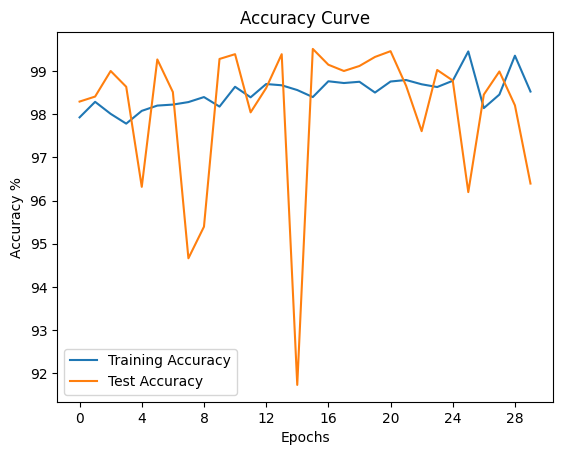

In [237]:
plt.figure()
plt.plot([acc * 100 for acc in history.history['accuracy']], label='Training Accuracy')
plt.plot([val_acc * 100 for val_acc in history.history['val_accuracy']], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.title('Accuracy Curve')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [238]:
 # Generate predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > DUB_share).astype(int)

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [239]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2222  327]
 [ 504 1342]]


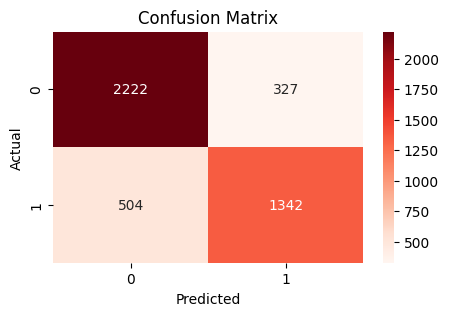

In [240]:
# Plot Confusion Matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [241]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.1%}')
print(f'Precision: {precision:.1%}')
print(f'Recall: {recall:.1%}')
print(f'F1 Score: {f1:.1%}')


Accuracy: 81.1%
Precision: 80.4%
Recall: 72.7%
F1 Score: 76.4%


AUC Score: 89.60%


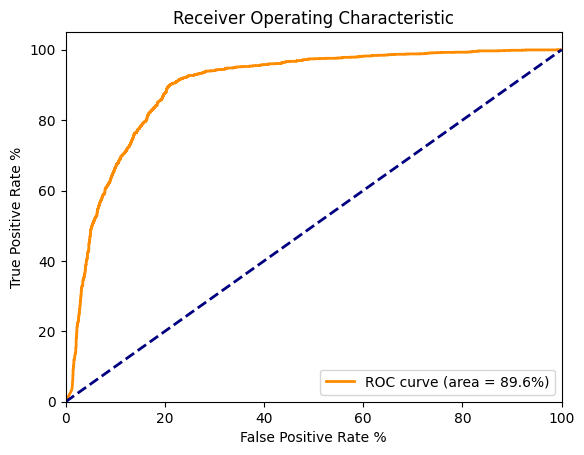

In [242]:
# AUC Score and Curve
auc_score = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f'AUC Score: {auc_score:.2%}')
#
plt.figure()
plt.plot(fpr*100, tpr*100, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.1%})')
plt.plot([0, 100], [0, 100], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 100])
plt.ylim([0.0, 105])
plt.xlabel('False Positive Rate %')
plt.ylabel('True Positive Rate %')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()